In [1]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from utils.utils_train import train_supervised, train_models_in_threads, test_model_in_batches
from utils.utils_plots import plot_first_feature, plot_interesting_features
from utils.utils_dataset import balance_dataset, prepare_dataset
from utils.utils_dataset import prepare_non_iid_dataset, plot_dataset_split, display_dataset_split
from utils.utils_metrics import calculate_metrics, plot_confusion_matrix, calculate_roc_auc
#%load_ext line_profiler



In [2]:
from model.eGauss_plus import eGAUSSp

In [3]:
# Load the dataset
file_path = 'Datasets/creditcard.csv'
data = pd.read_csv(file_path)

# Initialize the StandardScaler
scaler = StandardScaler()

# Select the columns to normalize - all except 'Class'
cols_to_normalize = [col for col in data.columns if col != 'Class']

# Apply the normalization
data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])


In [4]:
print(f"{torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [5]:
import itertools

if False:

    num_clients = 3

    # Define the range of values for each parameter
    num_sigma_values =  [1, 2, 3, 4, 5]
    kappa_join_values = [0.3, 0.5, 0.8]
    N_r_values = [10, 16, 20, 30]

    # Total number of experiments
    total_experiments = len(num_sigma_values) * len(kappa_join_values) * len(N_r_values)
    completed_experiments = 0

    # Define other parameters and data setup
    local_model_params = {
        "feature_dim": 30,
        "num_classes": 2,
        "kappa_n": 1,
        "S_0": 1e-3,
        "c_max": 100,
        "num_samples": 200, 
        "device": device  # Make sure 'device' is defined
    }

    # Placeholder for the best parameters and best score
    best_params = None
    best_score = 0

    # List to store all results
    results = []

    # Iterate over all combinations of parameters
    for num_sigma, kappa_join, N_r in itertools.product(num_sigma_values, kappa_join_values, N_r_values):
        # Update model parameters
        local_model_params.update({"num_sigma": num_sigma, "kappa_join": kappa_join, "N_r": N_r})

        # Prepare the dataset (assuming prepare_dataset function and data are defined)
        X = data.iloc[:, :-1].values
        y = data.iloc[:, -1].values
        client_train, test_data, all_data = prepare_dataset(X, y, num_clients, balance=100000)

        # Train the model on the first client's data and evaluate
        local_model = eGAUSSp(**local_model_params)
        train_supervised(local_model, client_train[0])  # Train on the first client's data

        _, pred_max, _ = test_model_in_batches(local_model, test_data)
        mertrics = calculate_metrics(pred_max, test_data, weight="binary")
        f1_score = mertrics["f1_score"]
        # Update best score and parameters if current score is better
        if f1_score > best_score:
            best_score = f1_score
            best_params = {"num_sigma": num_sigma, "kappa_join": kappa_join, "N_r": N_r}

        # Progress report
        completed_experiments += 1
        progress = completed_experiments / total_experiments * 100
        print(f"Experiment {completed_experiments}/{total_experiments} ({progress:.2f}%): "
              f"num_sigma={num_sigma}, kappa_join={kappa_join}, N_r={N_r}, F1 Score: {f1_score}")

        # Store the results
        results.append({
            "num_sigma": num_sigma,
            "kappa_join": kappa_join,
            "N_r": N_r,
            "f1_score": f1_score
        })
        
    # Print the best parameters and the corresponding F1 score
    print(f"Best F1 Score: {best_score}")
    print(f"Best Parameters: {best_params}")


In [6]:
import matplotlib.pyplot as plt

if False:
    # Assuming 'results' is your list of dictionaries containing the parameters and F1 scores
    results_df = pd.DataFrame(results)

    # Creating a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for each combination of parameters
    scatter = ax.scatter(results_df['num_sigma'], results_df['kappa_join'], results_df['N_r'], c=results_df['f1_score'], cmap='viridis')

    # Adding labels and title
    ax.set_xlabel('num_sigma')
    ax.set_ylabel('kappa_join')
    ax.set_zlabel('N_r')
    ax.set_title('F1 Score for Different Parameter Combinations')

    # Adding a color bar to represent F1 scores
    color_bar = fig.colorbar(scatter, ax=ax, pad=0.1)
    color_bar.set_label('F1 Score')

    plt.show()

In [7]:
import plotly.graph_objs as go
import pandas as pd

if False:
    results_df = pd.DataFrame(results)

    # Creating a 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=results_df['num_sigma'],
        y=results_df['kappa_join'],
        z=results_df['N_r'],
        mode='markers',
        marker=dict(
            size=5,
            color=results_df['f1_score'],  # Set color to the F1 scores
            colorscale='Viridis',  # Choose a colorscale
            opacity=0.8,
            colorbar=dict(title='F1 Score')
        )
    )])

    # Adding labels and title
    fig.update_layout(
        scene=dict(
            xaxis_title='num_sigma',
            yaxis_title='kappa_join',
            zaxis_title='N_r'
        ),
        title='F1 Score for Different Parameter Combinations'
    )

    fig.show()

In [8]:
# Model parameters
local_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "kappa_n": 10,
    "num_sigma": 20,
    "kappa_join": 0.4,
    "S_0": 1e-10,
    "N_r": 8,
    "c_max": 100,
    "num_samples": 200,
    "device": device
}

federated_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "kappa_n": 10,
    "num_sigma": 20,
    "kappa_join": 0.4,
    "S_0": 1e-10,
    "N_r": 8,
    "c_max": 200,
    "num_samples": 200,
    "device": device
}

In [9]:

#display_dataset_split(client_train, test_data)
#plot_dataset_split(client_train, test_data)

In [10]:

import cProfile
%load_ext line_profiler
%load_ext memory_profiler

import yappi

In [11]:
def compare_models(model1, model2):
    differences = []

    # Function to find differing indices within the overlapping range
    def find_differing_indices(tensor1, tensor2):
        min_length = min(tensor1.size(0), tensor2.size(0))
        differing = (tensor1[:min_length] != tensor2[:min_length]).nonzero(as_tuple=False)
        if differing.nelement() == 0:
            return "No differences"
        else:
            return differing.view(-1).tolist()  # Flatten and convert to list

    # Compare mu parameter and find differing indices
    mu_equal = torch.equal(model1.mu[:model1.c], model2.mu[:model2.c])
    if not mu_equal:
        differing_indices_mu = find_differing_indices(model1.mu[:model1.c], model2.mu[:model2.c])
        differences.append(f"mu parameter differs at indices {differing_indices_mu}")

    # Compare S parameter and find differing indices
    S_equal = torch.equal(model1.S[:model1.c], model2.S[:model2.c])
    if not S_equal:
        differing_indices_S = find_differing_indices(model1.S[:model1.c], model2.S[:model2.c])
        differences.append(f"S parameter differs at indices {differing_indices_S}")

    # Compare n parameter and find differing indices
    n_equal = torch.equal(model1.n[:model1.c], model2.n[:model2.c])
    if not n_equal:
        differing_indices_n = find_differing_indices(model1.n[:model1.c], model2.n[:model2.c])
        differences.append(f"n parameter differs at indices {differing_indices_n}")

    # Check if there are any differences
    if differences:
        difference_str = ", ".join(differences)
        return False, f"Differences found in: {difference_str}"
    else:
        return True, "Models are identical"


In [12]:
import torch.nn as nn

def run_experiment(num_clients, num_rounds, clients_data, test_data):
        
    # Initialize a model for each client
    local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
    federated_model = eGAUSSp(**federated_model_params)

    # Initialize a list to store the metrics for each round
    round_metrics = []

    for round in range(num_rounds):
        print(f"--- Communication Round {round + 1} ---")

        aggregated_model = eGAUSSp(**federated_model_params)
        federated_model = eGAUSSp(**federated_model_params)

        # Train local models
        train_models_in_threads(local_models, clients_data)
        
        '''
        for local_model, client_data in zip(local_models, clients_data):
             train_supervised(local_model, client_data)

             print(f"Number of local model clusters = {sum(local_model.n[0:local_model.c]> local_model.kappa_n)}")
             all_scores, pred_max, _ = test_model_in_batches(local_model, client_data)
             binary = calculate_metrics(pred_max, client_data, "binary")
             roc_auc = calculate_roc_auc(all_scores, client_data)
             print(f"Test Metrics: {binary}")
             print(f"Test ROC AUC: {roc_auc}")
             plot_confusion_matrix(pred_max, client_data)
        '''   

        # Update federated model with local models
        for client_idx, client_model in enumerate(local_models):
            #client_model.federal_agent.federated_merging()
            print(f"Updating agreggated model with client {client_idx + 1}")

            #client_model.federal_agent.federated_merging()
            aggregated_model.federal_agent.merge_model_privately(client_model, client_model.kappa_n)
            print(f"Number of agreggated clusters after transfer = {sum(aggregated_model.n[0:aggregated_model.c]> aggregated_model.kappa_n)}")
                
        aggregated_model.federal_agent.federated_merging()
        print(f"Number of agreggated clusters after merging = {sum(aggregated_model.n[0:aggregated_model.c]> aggregated_model.kappa_n)}")

                
        #client_model.score = 0*client_model.score  
        #aggregated_model.S_glo = client_model.S_glo
        #aggregated_model.mu_glo = client_model.mu_glo     
        '''
        if round>1:
            with torch.no_grad():
                aggregated_model.S = nn.Parameter(aggregated_model.S/2)
                aggregated_model.n = nn.Parameter(aggregated_model.n/2)

                aggregated_model.S_glo = aggregated_model.S_glo/2
                aggregated_model.n_glo = aggregated_model.n_glo/2
        '''

        # New code for comparison using the updated compare_models function
        #are_models_same, comparison_message = compare_models(client_model, aggregated_model)
        #print(f"Comparison details: {comparison_message}")

        # Update federated model with local models
        print(f"Updating federated model with agreggated model")
        federated_model = aggregated_model #.federal_agent.merge_model_privately(aggregated_model, federated_model.kappa_n)
        print(f"Number of federated clusters after transfer = {sum(federated_model.n[0:federated_model.c]> federated_model.kappa_n)}")

        local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]  
        
        # Perform federated merging and removal mechanism on the federated model
        if any(federated_model.n[0:federated_model.c]> federated_model.kappa_n):

            # Evaluate federated model
            all_scores_fed, pred_max_fed, _ = test_model_in_batches(federated_model, test_data, batch_size=500)
            binary_fed = calculate_metrics(pred_max_fed, test_data, "binary")
            roc_auc_fed = calculate_roc_auc(all_scores_fed, test_data)
            print(f"Test Metrics: {binary_fed}")
            print(f"Test ROC AUC: {roc_auc_fed}")

            plot_confusion_matrix(pred_max_fed, test_data)

            # Append metrics to the list
            round_metrics.append({
                'round': round + 1,
                'clusters': federated_model.c,
                'binary': binary_fed,
                'roc_auc': roc_auc_fed
            })

        # Return the updated federated model to each client
        for client_idx in range(len(local_models)):
            print(f"Returning updated model to client {client_idx + 1}")
            #local_models[client_idx] = federated_model
            
            local_models[client_idx].federal_agent.merge_model_privately(federated_model, federated_model.kappa_n)
            #local_models[client_idx].score = torch.zeros_like(local_models[client_idx].score)
            #local_models[client_idx].num_pred = torch.zeros_like(local_models[client_idx].score)
                      
            '''
            # Return the updated federated model to each client
            for client_idx, client_model in enumerate(local_models):
                print(f"Returning updated model to client {client_idx + 1}")
                client_model.federal_agent.merge_model_privately(federated_model, federated_model.kappa_n)
                client_model.federal_agent.federated_merging()
            '''
            
        print(f"--- End of Round {round + 1} ---\n")
        if  round == (num_rounds-1):
            plot_interesting_features(test_data, model=federated_model, num_sigma=2, N_max = federated_model.kappa_n)   
    
    # After all rounds
    print("All Rounds Completed. Metrics Collected:")
    for metric in round_metrics:
        print(f"Round {metric['round']}: Metrics: {metric['binary']}, ROC AUC: {metric['roc_auc']}")
        #print(f"                         Weighted: {metric['weighted']}")


    return round_metrics

Client 1: {0: 3334, 1: 3334}
Client 2: {0: 3333, 1: 3333}
Client 3: {0: 3333, 1: 3333}
Test Set: {0: 56864, 1: 98}

Combined Number of Samples per Class:
Class 0: 66864 samples
Class 1: 10098 samples

Total Number of Samples Across All Datasets: 76962
Running experiment with 3 clients and data configuration 1
... with profiler
--- Communication Round 1 ---
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Updating agreggated model with client 1
Number of agreggated clusters after transfer = 83
Updating agreggated model with client 2
Number of agreggated clusters after transfer = 178
Updating agreggated model with client 3
Number of agreggated clusters after transfer = 272
Number of agreggated clusters after merging = 180
Updating federated model with agreggated model
Number of federated clusters after transfer = 180
Evolving has been disabled.


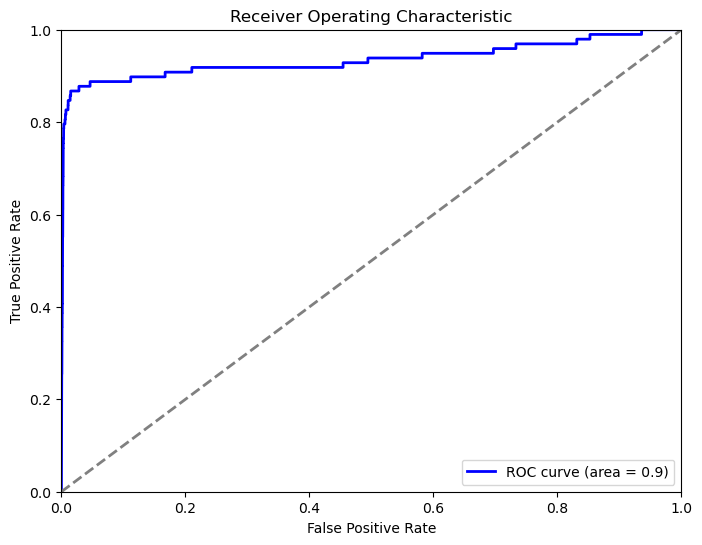

Test Metrics: {'accuracy': 0.979442435307749, 'precision': 0.06417546709991877, 'recall': 0.8061224489795918, 'f1_score': 0.11888638073739655}
Test ROC AUC: 0.9354382421933322


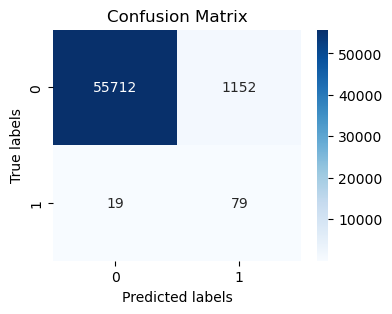

Returning updated model to client 1
Returning updated model to client 2
Returning updated model to client 3
--- End of Round 1 ---

--- Communication Round 2 ---
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Updating agreggated model with client 1
Number of agreggated clusters after transfer = 143
Updating agreggated model with client 2
Number of agreggated clusters after transfer = 286
Updating agreggated model with client 3
Number of agreggated clusters after transfer = 429
Number of agreggated clusters after merging = 314
Updating federated model with agreggated model
Number of federated clusters after transfer = 314
Evolving has been disabled.


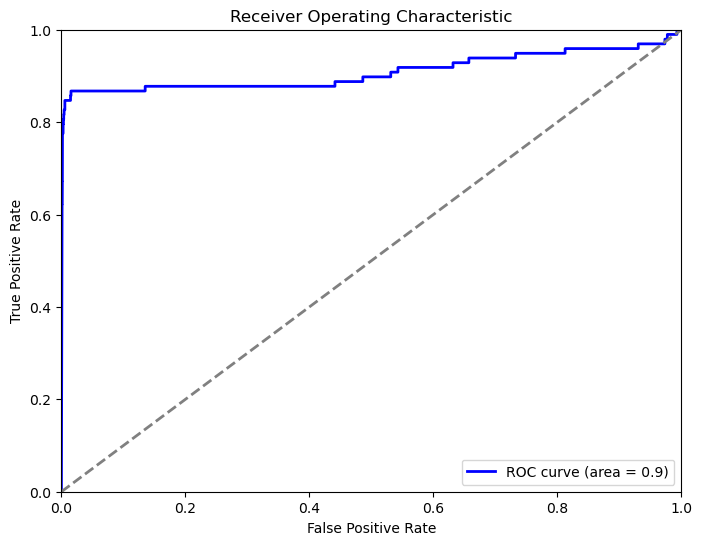

Test Metrics: {'accuracy': 0.9970682209192093, 'precision': 0.3333333333333333, 'recall': 0.7040816326530612, 'f1_score': 0.4524590163934426}
Test ROC AUC: 0.9085871194285254


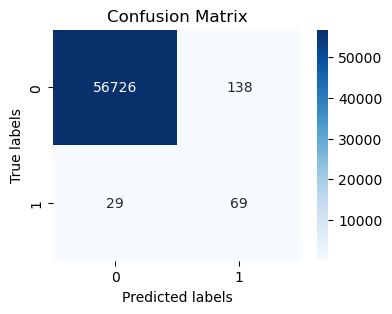

Returning updated model to client 1
Returning updated model to client 2
Returning updated model to client 3
--- End of Round 2 ---

--- Communication Round 3 ---
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Updating agreggated model with client 1
Number of agreggated clusters after transfer = 200
Updating agreggated model with client 2
Number of agreggated clusters after transfer = 400
Updating agreggated model with client 3
Number of agreggated clusters after transfer = 600
Number of agreggated clusters after merging = 400
Updating federated model with agreggated model
Number of federated clusters after transfer = 400
Evolving has been disabled.


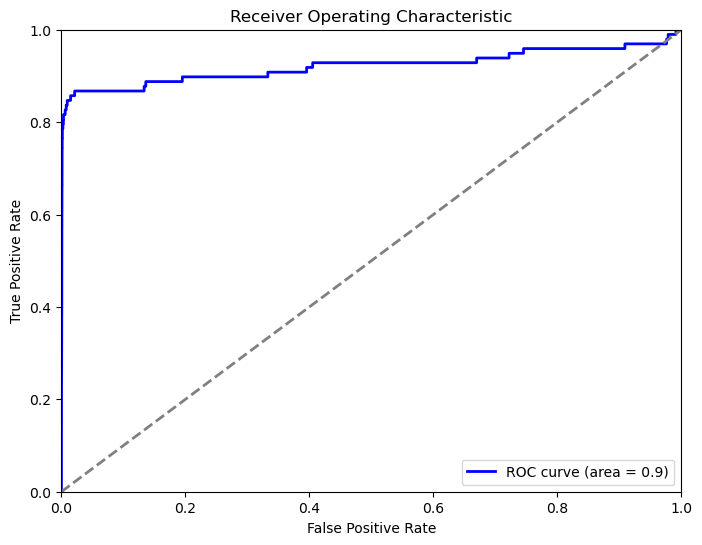

Test Metrics: {'accuracy': 0.9981917769741231, 'precision': 0.48226950354609927, 'recall': 0.6938775510204082, 'f1_score': 0.5690376569037657}
Test ROC AUC: 0.9214023362580823


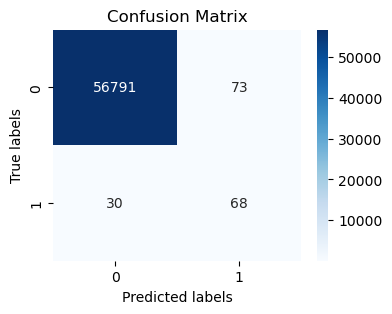

Returning updated model to client 1
Returning updated model to client 2
Returning updated model to client 3
--- End of Round 3 ---

--- Communication Round 4 ---
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Updating agreggated model with client 1
Number of agreggated clusters after transfer = 200
Updating agreggated model with client 2
Number of agreggated clusters after transfer = 400
Updating agreggated model with client 3
Number of agreggated clusters after transfer = 600
Number of agreggated clusters after merging = 400
Updating federated model with agreggated model
Number of federated clusters after transfer = 400
Evolving has been disabled.


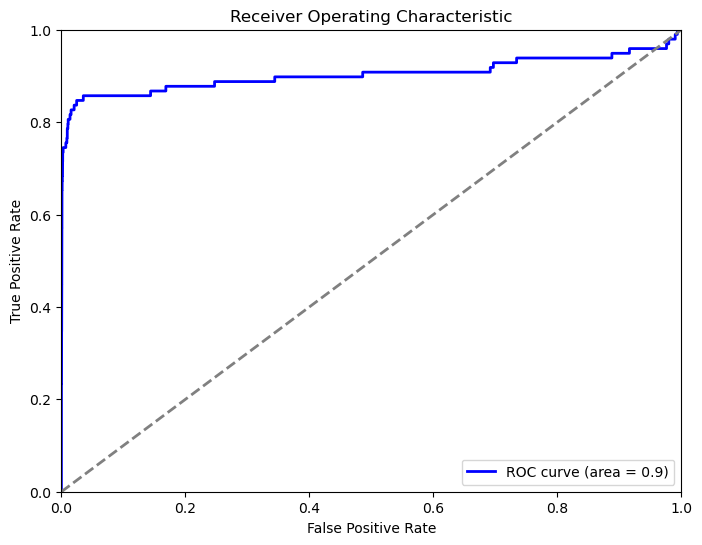

Test Metrics: {'accuracy': 0.9980337769039008, 'precision': 0.45394736842105265, 'recall': 0.7040816326530612, 'f1_score': 0.5519999999999999}
Test ROC AUC: 0.9034333081150299


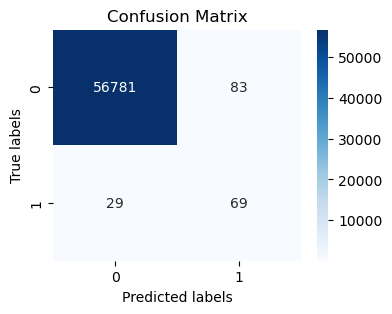

Returning updated model to client 1
Returning updated model to client 2
Returning updated model to client 3
--- End of Round 4 ---

--- Communication Round 5 ---
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Updating agreggated model with client 1
Number of agreggated clusters after transfer = 200
Updating agreggated model with client 2
Number of agreggated clusters after transfer = 400
Updating agreggated model with client 3
Number of agreggated clusters after transfer = 600
Number of agreggated clusters after merging = 400
Updating federated model with agreggated model
Number of federated clusters after transfer = 400
Evolving has been disabled.


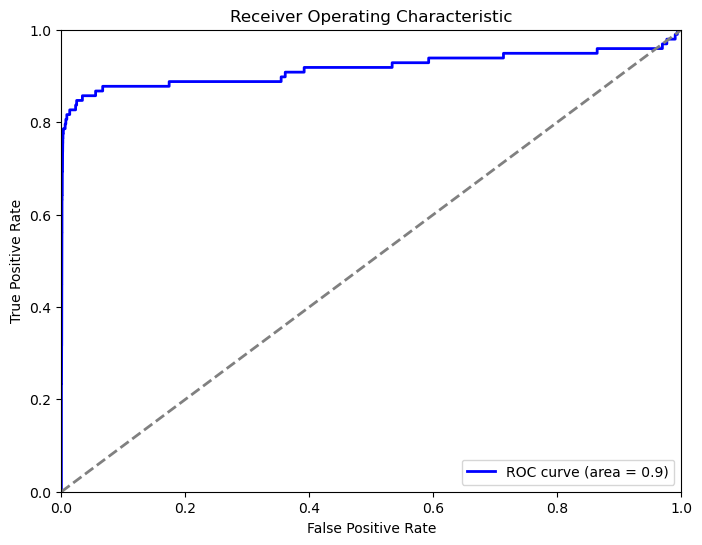

Test Metrics: {'accuracy': 0.9979811102138267, 'precision': 0.44654088050314467, 'recall': 0.7244897959183674, 'f1_score': 0.5525291828793775}
Test ROC AUC: 0.9162712250066036


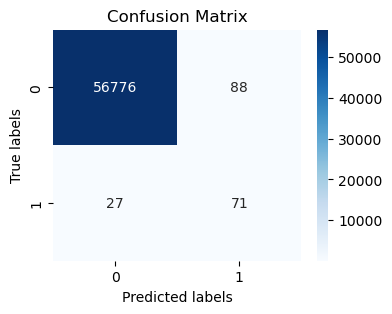

Returning updated model to client 1
Returning updated model to client 2
Returning updated model to client 3
--- End of Round 5 ---

--- Communication Round 6 ---
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.


In [13]:
# List of client counts and data configuration indices
client_counts = [3, 10]
data_config_indices = [1, 3, 1]  # Replace with your actual data configuration indices

# Assuming local_models, client_train, federated_model, and test_data are already defined
# Number of communication rounds
num_rounds = 10
profiler = True
experiments = []
# Running the experiment
for num_clients in client_counts:
    for data_config_index in data_config_indices:
        if data_config_index == 1:
            X = data.iloc[:, :-1].values
            y = data.iloc[:, -1].values
            client_train, test_data, all_data = prepare_dataset(X, y, num_clients, balance = 10000) 
            #'random', 'centroids', 'nearmiss', 'enn', 'smote', int num of samples
            
        if data_config_index == 3:
            X = data.iloc[:, :-1].values
            y = data.iloc[:, -1].values
            client_train, test_data, all_data = prepare_dataset(X, y, num_clients, balance = 'smote') 

        display_dataset_split(client_train, test_data)
        
        print(f"Running experiment with {num_clients} clients and data configuration {data_config_index}")
        if profiler:
            print(f"... with profiler")
            pr = cProfile.Profile()
            pr.enable()
            yappi.start()
            metrics =  run_experiment(num_clients, num_rounds, client_train, test_data)
            yappi.stop()
            pr.disable()

            pr.print_stats(sort='cumtime')
            yappi.get_thread_stats().print_all()
            yappi.get_func_stats().print_all()   
                   
        else:
            metrics = run_experiment(num_clients, num_rounds, client_train, test_data)
            experiments.append(metrics)

In [ ]:
print("All Rounds Completed. Metrics Collected:")
for metric in metrics:
    print(f"Round {metric['round']}: Metrics: {metric['binary']}, ROC AUC: {metric['roc_auc']}")
    print(f"                         Weighted: {metric['weighted']}")

In [ ]:
'''
for client_idx, client_model in enumerate(local_models):
        print(f"Merging client {client_idx + 1}")
        #print(f"Number of client {client_idx + 1} clusters before merging = {torch.sum(client_model.n[:client_model.c]>client_model.kappa_n)}")
        #client_model.federal_agent.federated_merging() 
        print(f"Number of client {client_idx + 1} after merging = {torch.sum(client_model.n[:client_model.c]>client_model.kappa_n)}")
        federated_model.federal_agent.merge_model_privately(client_model, client_model.kappa_n)

print(f"Number of clusters after transfer = {federated_model.c}")
'''

In [ ]:
'''
federated_model.federal_agent.federated_merging()
federated_model.removal_mech.removal_mechanism()
print(f"Number of clusters after merging = {federated_model.c}")
'''

In [ ]:

'''
print(f"\nTesting federated model")   

all_scores, pred_max, _ = test_model(federated_model, test_data)
metrics = calculate_metrics(pred_max, test_data, "binary")
print(f"Test Metrics: {metrics}")
roc_auc = calculate_roc_auc(all_scores, test_data)
print(f"Test ROC AUC: {roc_auc}")

plot_confusion_matrix(pred_max, test_data)
'''

In [ ]:

'''
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Confusion matrix values
tn = 135
fn = 10
tp = 132
fp = 19

# Creating the confusion matrix
y_true = [0]*tn + [1]*fn + [1]*tp + [0]*fp  # 0 for negative class, 1 for positive class
y_pred = [0]*(tn+fn) + [1]*(fp+tp)  # Predictions

# Calculating metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(accuracy, precision, recall, f1)
'''